In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy import wcs
from scipy.spatial import KDTree
from astropy.io import fits
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from regions import Region
from spectral_cube import SpectralCube
from astroquery.jplspec import JPLSpec
from astroquery.splatalogue import Splatalogue
from dust_extinction.averages import RL85_MWGC, RRP89_MWGC, B92_MWAvg, I05_MWAvg, CT06_MWLoc, CT06_MWGC, GCC09_MWAvg, F11_MWGC, G21_MWAvg, D22_MWAvg
from importlib import reload
from astropy.visualization import simple_norm

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
from jwst_plots import make_cat_use
from jwst_plots import JWSTCatalog
import cutout_manager as cm
import extinction as ex
import moment_maker as mm
import co_ice as co_map
reload(ex)
reload(co_map)

<module 'co_ice' from '/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/co_ice.py'>

In [4]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [5]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

# Mass over rectangle

## CO

In [89]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
fn_13CO = '/orange/adamginsburg/cmz/nobeyama/13CO-2.FOREST.FITS'
fn_C18O = '/orange/adamginsburg/cmz/nobeyama/C18O-2.FOREST.FITS'

In [90]:
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
cube_13CO = SpectralCube.read(fn_13CO, format='fits')
cube_C18O = SpectralCube.read(fn_C18O, format='fits')

## Strong et al 1988 X-Factor

In [8]:
subcube_12CO = cube_12CO.subcube_from_regions([reg])
subcube_12CO = subcube_12CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_12CO_mom0 = subcube_12CO.moment0()

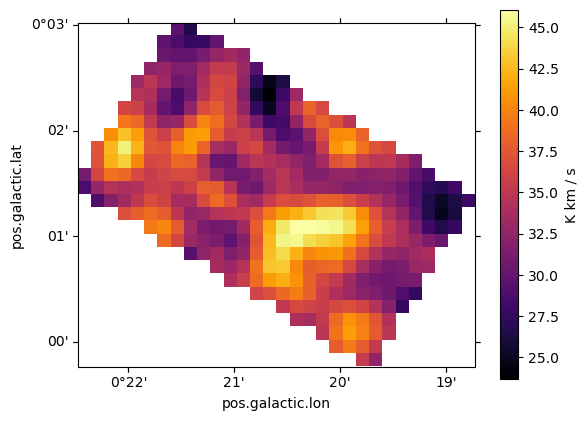

In [9]:
ax = plt.subplot(projection=subcube_12CO_mom0.wcs)
im = ax.imshow(subcube_12CO_mom0.value, origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, label=subcube_12CO_mom0.unit)

In [10]:
ww = subcube_12CO_mom0.wcs
subcube_N = np.nansum(subcube_12CO_mom0.value) * subcube_12CO_mom0.unit * 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
mass_Xfactor = (subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)
mass_Xfactor

<Quantity 2368.65646623 solMass>

In [11]:
coldens_Xfactor = np.nanmean(subcube_12CO_mom0)* 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
coldens_Xfactor

<Projection 8.02938156e+21 1 / cm2>

In [12]:
coldens_Xfactor_err = np.sqrt((np.nanstd(subcube_12CO_mom0)/np.nanmean(subcube_12CO_mom0))**2 + (0.3/2.3)**2)*coldens_Xfactor
coldens_Xfactor_err

<Projection 1.45755394e+21 1 / cm2>

In [13]:
mass_Xfactor_err = np.sqrt((coldens_Xfactor_err/coldens_Xfactor)**2)*mass_Xfactor
mass_Xfactor_err

<Projection 429.97639769 solMass>

## Isotopologue Masses

In [85]:
# Planck Function for blackbody radiation
def planck(T, nu):
    return (const.h*nu/const.k_B)/(np.exp(const.h*nu/(const.k_B*T))-1)

def get_S(J):
    return J / (2*J + 1)

def get_Qrot(Tex, B):
    return (const.k_B * Tex) / (const.h * B) + 1/3 

def query_JLP(mol):
    response = JPLSpec.query_lines(min_frequency=100 * u.GHz,
                                   max_frequency=1000 * u.GHz,
                                   min_strength=-500,
                                   molecule=mol,
                                   get_query_payload=False)
    return response

def query_splat(mol):
    return Splatalogue.query_lines(1*u.mm, 3*u.mm, chemical_name=mol, energy_type='eu_k', only_NRAO_recommended=True, energy_max=50)[0]

In [86]:
co_abundance = 10**(-4)

### 13CO

In [87]:
def get_13CO_10_N(Tex, I, Ju=1):
    mu = (1.1046*10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
    B = 55101.011 * u.MHz
    Q_rot = get_Qrot(Tex, B)
    S = get_S(Ju)
    Ri = 1
    f = 1
    jpl = query_JLP("29001 C-13-O")
    freq = jpl['FREQ'].to(u.GHz)[Ju-1]
    splat = query_splat(' 13CO ')
    Eu = splat['upper_state_energy_K'] * u.K
    gu = jpl['GUP'][Ju-1]

    N = (3 * const.h * Q_rot)/(8 * np.pi**3 * S * mu**2 * Ri * gu) 
    N *= np.exp(Eu/(Tex))/(np.exp(const.h*freq/(const.k_B*Tex))-1) 
    N *= (f * (planck(Tex, freq)-planck(2.73*u.K, freq)))**(-1)
    N = N*I

    return N.to(u.cm**(-2))

In [17]:
subcube_13CO = cube_13CO.subcube_from_regions([reg])
subcube_13CO = subcube_13CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_13CO_mom0 = subcube_13CO.moment0()

In [18]:
column_density_13CO = get_13CO_10_N(20*u.K, subcube_13CO_mom0)

In [ ]:
ratio_12C_13C = 53 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_13CO_mom0.header)
N_13CO = np.nansum(column_density_13CO.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_13CO = N_13CO * pixel_physical_area * 2.8 * u.Da
mass_13CO = M_13CO.to(u.M_sun) * ratio_12C_13C / co_abundance
mass_13CO

<Quantity 2323.28420177 solMass>

In [139]:
ratio_12C_13C_GC = 20 # from Wilson & Rood 1994
mass_13CO_GC = M_13CO.to(u.M_sun) * ratio_12C_13C_GC / co_abundance
mass_13CO_GC

<Quantity 876.71101953 solMass>

In [20]:
coldens_13CO = np.nanmean(column_density_13CO) * ratio_12C_13C / co_abundance
coldens_13CO

<Projection 7.87557686e+21 1 / cm2>

In [21]:
coldens_13CO_err = coldens_13CO*(np.nanstd(subcube_13CO_mom0)/np.nanmean(subcube_13CO_mom0))
coldens_13CO_err

<Projection 1.45043015e+21 1 / cm2>

In [22]:
mass_13CO_err = mass_13CO * coldens_13CO_err / coldens_13CO
mass_13CO_err

<Projection 427.87487265 solMass>

### C18O

In [88]:
def get_C18O_10_N(Tex, I, Ju=1):
    mu = (1.1079*10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
    B = 54891.420 * u.MHz
    Q_rot = get_Qrot(Tex, B)
    S = get_S(Ju)
    Ri = 1
    f = 1
    jpl = query_JLP("29001 CO-18")
    freq = jpl['FREQ'].to(u.GHz)[Ju-1]
    splat = query_splat(' C18O ')
    Eu = splat['upper_state_energy_K'] * u.K
    gu = jpl['GUP'][Ju-1]

    N = (3 * const.h * Q_rot)/(8 * np.pi**3 * S * mu**2 * Ri * gu) 
    N *= np.exp(Eu/(Tex))/(np.exp(const.h*freq/(const.k_B*Tex))-1) 
    N *= (f * (planck(Tex, freq)-planck(2.73*u.K, freq)))**(-1) 
    N = N*I

    return N.to(u.cm**(-2))

In [24]:
subcube_C18O = cube_C18O.subcube_from_regions([reg])
subcube_C18O = subcube_C18O.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_C18O_mom0 = subcube_C18O.moment0()

In [25]:
column_density_C18O = get_C18O_10_N(20*u.K, subcube_C18O_mom0)

In [26]:
ratio_16O_18O = 327 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_C18O_mom0.header)
N_C18O = np.nansum(column_density_C18O.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_C18O = N_C18O * pixel_physical_area * 2.8 * u.Da
mass_C18O = M_C18O.to(u.M_sun) * ratio_16O_18O / co_abundance
mass_C18O

<Quantity 3492.91941135 solMass>

In [138]:
ratio_16O_18O_GC = 250 # from Wilson & Rood 1994
mass_C18O_GC = M_C18O.to(u.M_sun) * ratio_16O_18O_GC / co_abundance
mass_C18O_GC

<Quantity 2670.42768452 solMass>

In [27]:
coldens_C18O = np.nanmean(column_density_C18O) * ratio_16O_18O / co_abundance
coldens_C18O

<Projection 1.18404607e+22 1 / cm2>

In [28]:
coldens_C18O_err = coldens_C18O*(np.nanstd(subcube_C18O_mom0)/np.nanmean(subcube_C18O_mom0))
coldens_C18O_err

<Projection 4.80938755e+21 1 / cm2>

In [29]:
mass_C18O_err = mass_C18O * coldens_C18O_err / coldens_C18O
mass_C18O_err

<Projection 1418.76262681 solMass>

## Extinction Mass

In [6]:
ext_map = ex.make_extinction_map(Av_fill=85)
ww = ex.get_wcs()
mass_extinction = ex.get_mass_estimate(ext_map, ww)
mass_extinction

<Quantity 8326.96602284 solMass>

In [7]:
ext_laws = [RL85_MWGC(), RRP89_MWGC(), I05_MWAvg(), CT06_MWLoc(), CT06_MWGC(), F11_MWGC(), G21_MWAvg(), D22_MWAvg()]
av_fills = [70, 80, 80, 85, 85, 60, 75, 76]
av_masses = []
for i, ext in enumerate(ext_laws):
    ext_mapp = ex.make_extinction_map(ext=ext, Av_fill=av_fills[i])
    av_masses.append(ex.get_mass_estimate(ext_mapp, ww).value)

print('Max:', np.max(av_masses), 'Min:', np.min(av_masses))

Max: 8326.966022835555 Min: 6441.287282770235


In [8]:
ext_N = ext_map*2.21*10**21*u.cm**-2
coldens_extinction = np.nanmean(ext_N)
coldens_extinction

<Quantity 2.82476997e+22 1 / cm2>

In [9]:
ext_map_CT06 = ex.make_extinction_map(ext=CT06_MWGC(), Av_fill=85)
ext_map_F11 = ex.make_extinction_map(ext=F11_MWGC(), Av_fill=60)

In [10]:
# 2.21 +/- 0.09 x 10**21
#ext_N_CT06 = ext_map_CT06*2.21*10**21*u.cm**-2
#ext_N_F11 = ext_map_F11*2.21*10**21*u.cm**-2
#
#coldens_extinction_CT06 = np.nanmean(ext_N_CT06)
#coldens_extinction_F11 = np.nanmean(ext_N_F11)

coldens_extinction_err = np.sqrt((np.nanstd(ext_N)/np.nanmean(ext_N))**2 + (0.09/2.21)**2)*coldens_extinction
coldens_extinction_err

<Quantity 3.48827802e+22 1 / cm2>

## PPMAP

In [34]:
ppmap = '/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/l000_results/l000_cdens.fits'

In [35]:
r0 = reg#[0]
hdul = fits.open(ppmap)
ww = wcs.WCS(hdul[0].header)
preg = r0.to_pixel(ww)
mask = preg.to_mask()
cutout = mask.cutout(hdul[0].data)
#pixelarea = 1*u.pixel
cden = (mask.multiply(hdul[0].data) * (10**20) * u.cm**(-2))
        #* u.Unit(hdul[0].header['BUNIT']))
u.Unit(hdul[0].header['BUNIT'])

Unit("1e+20 / cm2")

In [36]:
coldens_ppmap = np.nanmean(cden)
coldens_ppmap

<Quantity 2.44691751e+22 1 / cm2>

In [37]:
pix_area_2 = ww.celestial.proj_plane_pixel_area()
pix_area_cm_2 = (pix_area_2 * (5*u.kpc)**2).to(u.parsec**2, equivalencies=u.dimensionless_angles()).to(u.cm**2)
mass_ppmap = (pix_area_cm_2 * cden * u.Da*2.8).to(u.M_sun).sum()
mass_ppmap

<Quantity 15287.31118604 solMass>

In [38]:
coldens_ppmap_err = mask.multiply(fits.open('/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/l000_results/l000_sigdiffcdens.fits')[0].data[5]).mean()* (10**20) * u.cm**(-2)#*u.Unit(hdul[0].header['BUNIT'])
coldens_ppmap_err 

<Quantity 4.14044193e+20 1 / cm2>

In [39]:
mass_ppmap_err = mass_ppmap * coldens_ppmap_err / coldens_ppmap
mass_ppmap_err

<Quantity 258.67739222 solMass>

## CO Ice

In [69]:
co_column_map = co_map.make_co_column_map()

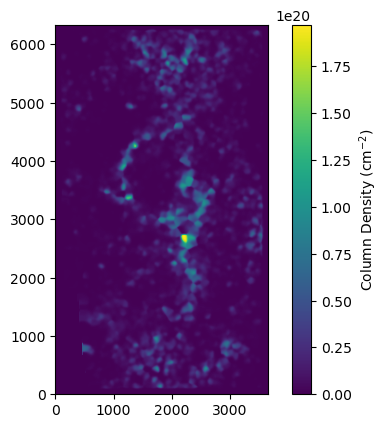

In [70]:
im = plt.imshow(co_column_map, origin='lower')
plt.colorbar(im, label='Column Density (cm$^{-2}$)')

In [71]:
co_abundance = 10**(-4)
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5*u.kpc).to(u.cm, u.dimensionless_angles())**2
mpp = 2.8*u.Da
# grid_interp = N(CO) map after interpolation
mass_co_ice = (np.nansum(co_column_map) * u.cm**(-2) * pixel_area_physical * mpp / co_abundance).to(u.Msun)
mass_co_ice

<Quantity 21004.13860021 solMass>

In [ ]:
mass_co_ice_err = np.nan*u.Msun

In [ ]:
coldens_co_ice = np.nanmean(co_column_map) * u.cm**(-2) / co_abundance

In [ ]:
coldens_co_ice_err = np.nanstd(co_column_map) * u.cm**(-2) / co_abundance

## Mass Table

In [ ]:
methods = ['A$_V times 2e21$', '$^{12}CO$ X-factor', '$^{13}$CO LTE', 'C$^{18}$O LTE', 'PPMAP', 'CO Ice']
masses = [mass_extinction, mass_Xfactor, mass_13CO, mass_C18O, mass_ppmap, mass_co_ice]
masses_err = [mass_extinction_err, mass_Xfactor_err, mass_13CO_err, mass_C18O_err, mass_ppmap_err]
coldens = [coldens_extinction, coldens_Xfactor, coldens_13CO, coldens_C18O, coldens_ppmap]
coldens_err = [coldens_extinction_err, coldens_Xfactor_err, coldens_13CO_err, coldens_C18O_err, coldens_ppmap_err]

column_names = ['Method', 'Mass', 'Mass Error', 'Column Density', 'Column Density Error']

In [131]:
for i in range(len(methods)):
    print(methods[i], masses[i], masses_err[i], coldens[i]*10**22, coldens_err[i]*10**22)
    masses[i] = int(masses[i].value)*u.M_sun
    masses_err[i] = int(masses_err[i].value)*u.M_sun
    column_density[i] = np.round(coldens[i].value/10**22*u.cm**-2, 2)
    column_density_err[i] = np.round(coldens_err[i].value/10**22*u.cm**-2, 2)

A$_V times 2e21$ 20326.089992822755 solMass 2788.9034782794915 solMass 6.895251951673146e+44 1 / cm2 3.1675666328029433e+44 1 / cm2
$^{12}CO$ X-factor 2368.6564662298774 solMass 429.9763976879777 solMass 8.029381561279297e+43 1 / cm2 1.4575539376870044e+43 1 / cm2
$^{13}$CO LTE 2323.28420176602 solMass 427.87487264843867 solMass 7.875576855020133e+43 1 / cm2 1.4504301459602926e+43 1 / cm2
C$^{18}$O LTE 3492.919411351405 solMass 1418.7626268094068 solMass 1.184046069421002e+44 1 / cm2 4.809387546290829e+43 1 / cm2
PPMAP 15287.311186037461 solMass 258.6773922152559 solMass 2.446917514944868e+44 1 / cm2 4.140441926176552e+42 1 / cm2


In [132]:
tbl = Table([methods, masses, masses_err, column_density, column_density_err], names=column_names)
tbl

Method,Mass,Mass Error,Column Density,Column Density Error
,solMass,solMass,1 / cm2,1 / cm2
str18,float64,float64,float64,float64
A$_V times 2e21$,20326.0,2788.0,6.9,3.17
$^{12}CO$ X-factor,2368.0,429.0,0.8,0.15
$^{13}$CO LTE,2323.0,427.0,0.79,0.15
C$^{18}$O LTE,3492.0,1418.0,1.18,0.48
PPMAP,15287.0,258.0,2.45,0.04


In [133]:
tbl.write('masses_table.tex', format='ascii.latex', overwrite=True)

# Mass within region

In [11]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')

## Strong et al 1988

In [91]:
subcube_12CO = cube_12CO.subcube_from_regions(reg_f)
subcube_12CO = subcube_12CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_12CO_mom0 = subcube_12CO.moment0()

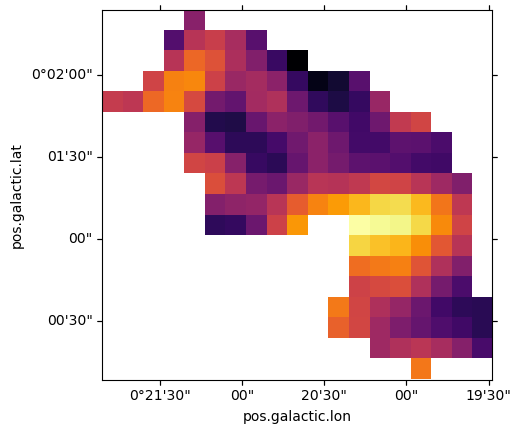

In [92]:
ax = plt.subplot(projection=subcube_12CO_mom0.wcs)
im = ax.imshow(subcube_12CO_mom0.value, origin='lower', cmap='inferno')

In [93]:
ww = subcube_12CO_mom0.wcs
subcube_N = np.nansum(subcube_12CO_mom0.value) * subcube_12CO_mom0.unit * 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
mass_Xfactor = (subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)
mass_Xfactor

<Quantity 935.29761534 solMass>

In [94]:
coldens_Xfactor = np.nanmean(subcube_12CO_mom0)* 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
coldens_Xfactor

<Projection 8.25569218e+21 1 / cm2>

In [95]:
coldens_Xfactor_err = np.sqrt((np.nanstd(subcube_12CO_mom0)/np.nanmean(subcube_12CO_mom0))**2 + (0.3/2.3)**2)*coldens_Xfactor
coldens_Xfactor_err

<Projection 1.40741997e+21 1 / cm2>

In [96]:
mass_Xfactor_err = np.sqrt((coldens_Xfactor_err/coldens_Xfactor)**2)*mass_Xfactor
mass_Xfactor_err

<Projection 159.448356 solMass>

## Isotopologue Mass

### 13CO

In [97]:
subcube_13CO = cube_13CO.subcube_from_regions(reg_f)
subcube_13CO = subcube_13CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_13CO_mom0 = subcube_13CO.moment0()

In [98]:
column_density_13CO = get_13CO_10_N(20*u.K, subcube_13CO_mom0)

In [99]:
ratio_12C_13C = 53 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_13CO_mom0.header)
N_13CO = np.nansum(column_density_13CO.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_13CO = N_13CO * pixel_physical_area * 2.8 * u.Da
mass_13CO = M_13CO.to(u.M_sun) * ratio_12C_13C / co_abundance
mass_13CO

<Quantity 980.90149717 solMass>

In [100]:
ratio_12C_13C_GC = 20 # from Wilson & Rood 1994
mass_13CO_GC = M_13CO.to(u.M_sun) * ratio_12C_13C_GC / co_abundance
mass_13CO_GC

<Quantity 370.15150836 solMass>

In [101]:
coldens_13CO = np.nanmean(column_density_13CO) * ratio_12C_13C / co_abundance
coldens_13CO

<Projection 8.65822931e+21 1 / cm2>

In [102]:
coldens_13CO_err = coldens_13CO*(np.nanstd(subcube_13CO_mom0)/np.nanmean(subcube_13CO_mom0))
coldens_13CO_err

<Projection 9.64345805e+20 1 / cm2>

In [103]:
mass_13CO_err = mass_13CO * coldens_13CO_err / coldens_13CO
mass_13CO_err

<Projection 109.25192778 solMass>

### C18O

In [104]:
subcube_C18O = cube_C18O.subcube_from_regions(reg_f)
subcube_C18O = subcube_C18O.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_C18O_mom0 = subcube_C18O.moment0()

In [105]:
column_density_C18O = get_C18O_10_N(20*u.K, subcube_C18O_mom0)

In [106]:
ratio_16O_18O = 327 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_C18O_mom0.header)
N_C18O = np.nansum(column_density_C18O.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_C18O = N_C18O * pixel_physical_area * 2.8 * u.Da
mass_C18O = M_C18O.to(u.M_sun) * ratio_16O_18O / co_abundance
mass_C18O

<Quantity 1752.29028913 solMass>

In [107]:
ratio_16O_18O_GC = 250 # from Wilson & Rood 1994
mass_C18O_GC = M_C18O.to(u.M_sun) * ratio_16O_18O_GC / co_abundance
mass_C18O_GC

<Quantity 1339.67147487 solMass>

In [108]:
coldens_C18O = np.nanmean(column_density_C18O) * ratio_16O_18O / co_abundance
coldens_C18O

<Projection 1.54671302e+22 1 / cm2>

In [109]:
coldens_C18O_err = coldens_C18O*(np.nanstd(subcube_C18O_mom0)/np.nanmean(subcube_C18O_mom0))
coldens_C18O_err

<Projection 3.34117332e+21 1 / cm2>

In [110]:
mass_C18O_err = mass_C18O * coldens_C18O_err / coldens_C18O
mass_C18O_err

<Projection 378.52565399 solMass>

## Extinction

In [12]:
ext_map = ex.make_extinction_map(Av_fill=85, reg=reg_f)
ext_map[ext_map < 1] = np.nan
ww = ex.get_wcs()
mass_extinction = ex.get_mass_estimate(ext_map, ww)
mass_extinction

<Quantity 6531.71390553 solMass>

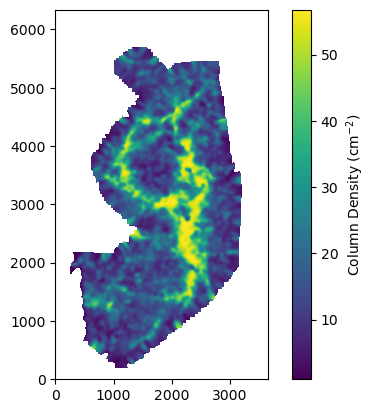

In [ ]:
im = plt.imshow(ext_mapp, origin='lower')
plt.colorbar(im, label='Av')

In [20]:
ext_laws = [RL85_MWGC(), RRP89_MWGC(), I05_MWAvg(), CT06_MWLoc(), CT06_MWGC(), F11_MWGC(), G21_MWAvg(), D22_MWAvg()]
av_fills = [70, 80, 80, 85, 85, 60, 75, 76]
av_masses = []
for i, ext in enumerate(ext_laws):
    ext_mapp = ex.make_extinction_map(ext=ext, Av_fill=av_fills[i], reg=reg_f)
    ext_mapp[ext_mapp < 1] = np.nan
    av_masses.append(ex.get_mass_estimate(ext_mapp, ww).value)

print('Max:', np.max(av_masses), 'Min:', np.min(av_masses))

Max: 6531.713905531625 Min: 4828.280320150819


In [14]:
mass_extinction_err = 0*u.Msun

In [15]:
ext_N = ext_map*2.21*10**21*u.cm**-2
coldens_extinction = np.nanmean(ext_N)
coldens_extinction

<Quantity 4.81288178e+22 1 / cm2>

In [114]:
ext_map_CT06 = ex.make_extinction_map(ext=CT06_MWGC(), Av_fill=85, reg=reg_f)
ext_map_F11 = ex.make_extinction_map(ext=F11_MWGC(), Av_fill=60, reg=reg_f)

In [16]:
# 2.21 +/- 0.09 x 10**21
#ext_N_CT06 = ext_map_CT06*2.21*10**21*u.cm**-2
#ext_N_F11 = ext_map_F11*2.21*10**21*u.cm**-2
#
#coldens_extinction_CT06 = np.nanmean(ext_N_CT06)
#coldens_extinction_F11 = np.nanmean(ext_N_F11)

coldens_extinction_err = np.sqrt((np.nanstd(ext_N)/np.nanmean(ext_N))**2 + (0.09/2.21)**2)*coldens_extinction
coldens_extinction_err

<Quantity 3.14553885e+22 1 / cm2>

## PPMAP

In [116]:
ppmap = '/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/l000_results/l000_cdens.fits'

In [117]:
r0 = reg_f[0]
hdul = fits.open(ppmap)
ww = wcs.WCS(hdul[0].header)
preg = r0.to_pixel(ww)
mask = preg.to_mask()
cutout = mask.cutout(hdul[0].data)
#pixelarea = 1*u.pixel
cden = (mask.multiply(hdul[0].data) * (10**20) * u.cm**(-2))
        #* u.Unit(hdul[0].header['BUNIT']))
u.Unit(hdul[0].header['BUNIT'])

Unit("1e+20 / cm2")

In [118]:
coldens_ppmap = np.nanmean(cden)
coldens_ppmap

<Quantity 2.08165246e+22 1 / cm2>

In [119]:
pix_area_2 = ww.celestial.proj_plane_pixel_area()
pix_area_cm_2 = (pix_area_2 * (5*u.kpc)**2).to(u.parsec**2, equivalencies=u.dimensionless_angles()).to(u.cm**2)
mass_ppmap = (pix_area_cm_2 * cden * u.Da*2.8).to(u.M_sun).sum()
mass_ppmap

<Quantity 5413.96636566 solMass>

In [120]:
coldens_ppmap_err = mask.multiply(fits.open('/orange/adamginsburg/galactic_plane_surveys/higal/PPMAP_Results/l000_results/l000_sigdiffcdens.fits')[0].data[5]).mean()* (10**20) * u.cm**(-2)#*u.Unit(hdul[0].header['BUNIT'])
coldens_ppmap_err 

<Quantity 3.77682876e+20 1 / cm2>

In [121]:
mass_ppmap_err = mass_ppmap * coldens_ppmap_err / coldens_ppmap
mass_ppmap_err

<Quantity 98.22784687 solMass>

## CO Ice

In [122]:
co_column_map = co_map.make_co_column_map(reg=reg_f)
ww = ex.get_wcs()

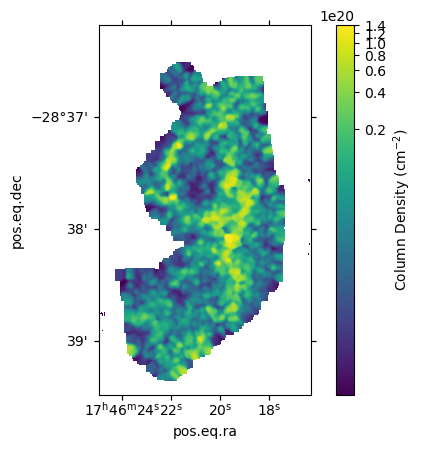

In [123]:
ax = plt.subplot(projection=ww)
co_column_map[co_column_map<1] = np.nan
im = ax.imshow(co_column_map, origin='lower', norm=simple_norm(co_column_map, stretch='log', max_percent=99.9))
plt.colorbar(im, ax=ax, label='Column Density (cm$^{-2}$)')

In [124]:
co_abundance = 10**(-4)
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5*u.kpc).to(u.cm, u.dimensionless_angles())**2
mpp = 2.8*u.Da
# grid_interp = N(CO) map after interpolation
mass_co_ice = co_map.get_mass_estimate(co_column_map, ww)
mass_co_ice

<Quantity 13959.22071323 solMass>

In [142]:
mass_co_ice_err = 0*u.Msun

In [125]:
ext_laws = [RL85_MWGC(), RRP89_MWGC(), I05_MWAvg(), CT06_MWLoc(), CT06_MWGC(), F11_MWGC(), G21_MWAvg(), D22_MWAvg()]
ice_masses = []
for i, ext in enumerate(ext_laws):
    co_coll = co_map.make_co_column_map(ext=ext, reg=reg_f)
    ice_masses.append(co_map.get_mass_estimate(co_coll, ww).value)

print('Max:', np.max(ice_masses), 'Min:', np.min(ice_masses))

Max: 28098.680616793063 Min: 8546.791355374287


In [126]:
ice_masses

[8574.10897742836,
 8546.791355374287,
 13568.311353556175,
 13959.220713232155,
 13959.220713232155,
 28098.680616793063,
 10482.862296073732,
 11192.130464439006]

In [127]:
coldens_co_ice = np.nanmean(co_column_map) * u.cm**(-2) / co_abundance
coldens_co_ice

<Quantity 9.1737629e+22 1 / cm2>

In [128]:
coldens_co_ice_err = np.nanstd(co_column_map) * u.cm**(-2) / co_abundance
coldens_co_ice_err

<Quantity 1.64145642e+23 1 / cm2>

## Mass Table

In [143]:
methods = ['A$_V times 2e21$', '$^{12}CO$ X-factor', '$^{13}$CO LTE', 'C$^{18}$O LTE', 'PPMAP', 'CO Ice']
masses = [mass_extinction, mass_Xfactor, mass_13CO, mass_C18O, mass_ppmap, mass_co_ice]
masses_err = [mass_extinction_err, mass_Xfactor_err, mass_13CO_err, mass_C18O_err, mass_ppmap_err, mass_co_ice_err]
coldens = [coldens_extinction, coldens_Xfactor, coldens_13CO, coldens_C18O, coldens_ppmap, coldens_co_ice]
coldens_err = [coldens_extinction_err, coldens_Xfactor_err, coldens_13CO_err, coldens_C18O_err, coldens_ppmap_err, coldens_co_ice_err]

column_names = ['Method', 'Mass', 'Mass Error', 'Column Density', 'Column Density Error']

In [144]:
for i in range(len(methods)):
    print(methods[i], masses[i], masses_err[i], coldens[i]*10**22, coldens_err[i]*10**22)
    masses[i] = int(masses[i].value)*u.M_sun
    masses_err[i] = int(masses_err[i].value)*u.M_sun
    coldens[i] = np.round(coldens[i].value/10**22*u.cm**-2, 2)
    coldens_err[i] = np.round(coldens_err[i].value/10**22*u.cm**-2, 2)

A$_V times 2e21$ 13201.878626620819 solMass 0.0 solMass 9.46995503620781e+44 1 / cm2 3.2310361198444932e+44 1 / cm2
$^{12}CO$ X-factor 935.2976153438766 solMass 159.44835600131296 solMass 8.255692176818847e+43 1 / cm2 1.4074199737617071e+43 1 / cm2
$^{13}$CO LTE 980.9014971661892 solMass 109.25192777970598 solMass 8.658229313408333e+43 1 / cm2 9.643458047330889e+42 1 / cm2
C$^{18}$O LTE 1752.2902891307085 solMass 378.5256539946964 solMass 1.5467130176458273e+44 1 / cm2 3.341173321441749e+43 1 / cm2
PPMAP 5413.966365655633 solMass 98.22784687242361 solMass 2.08165245609007e+44 1 / cm2 3.776828758958457e+42 1 / cm2
CO Ice 13959.220713232155 solMass 0.0 solMass 9.173762898503717e+44 1 / cm2 1.641456422178309e+45 1 / cm2


In [146]:
tbl = Table([methods, masses, masses_err, coldens, coldens_err], names=column_names)
tbl

Method,Mass,Mass Error,Column Density,Column Density Error
,solMass,solMass,1 / cm2,1 / cm2
str18,float64,float64,float64,float64
A$_V times 2e21$,13201.0,0.0,9.47,3.23
$^{12}CO$ X-factor,935.0,159.0,0.83,0.14
$^{13}$CO LTE,980.0,109.0,0.87,0.1
C$^{18}$O LTE,1752.0,378.0,1.55,0.33
PPMAP,5413.0,98.0,2.08,0.04
CO Ice,13959.0,0.0,9.17,16.41


In [147]:
tbl.write('masses_table_reg.tex', format='ascii.latex', overwrite=True)